# Transmilenio analysis
**Objectives**:
1. To identify patterns of Transmilenio buses demand in different periods
2. To group Transmilenio stations based in their similarities
3. To correlate transport demand evolution with the location of stations

In [116]:
# Necessary libraries for Data Science :)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import seaborn as sns

# For geospatial data manipulation
import geopandas as gpd

In [117]:
# Pandas tools for time series plots
from pandas import Grouper
from pandas.plotting import lag_plot
from pandas.plotting import autocorrelation_plot

# Statsmodels tools for time series analysis
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Sklearn tools for train test split and model evaluation
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

In [118]:
# Animation packages
import time
from IPython import display

## 1. Exploratory Data Analysis
The dataset comes from Bogota open data web page: https://datosabiertos.bogota.gov.co/
The data represents the number of bus departures per day from January to April 2020. The number of departures were measured every 15 minutes each day.

In [119]:
df = pd.read_csv("consolidado-de-salidas-sistema-troncal-por-franja-horaria-enero-abril-2020.csv",
                 encoding='latin-1', header=0,sep=';')

C:\Users\juanc\AppData\Local\Temp\ipykernel_11056\2727227040.py:1: DtypeWarning: Columns (34,35) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("consolidado-de-salidas-sistema-troncal-por-franja-horaria-enero-abril-2020.csv",


In [120]:
df.head(3)

,Zona,Estación,Acceso de Estación,Mes,INTERVALO,Día 1,Día 2,Día 3,Día 4,Día 5,...,Día 25,Día 26,Día 27,Día 28,Día 29,Día 30,Día 31,Total general,Unnamed: 37,Unnamed: 38
0,(11) Zona K Calle 26,(06000) Portal Eldorado,(01) PLAT2 ALIM-DESAL FONTIBÓN/FONTIBÓN CENTRO...,Enero,00:00,6,0.0,10.0,29.0,7.0,...,24.0,26.0,2.0,2.0,5.0,10.0,18.0,392.0,NaN,NaN
1,(11) Zona K Calle 26,(06000) Portal Eldorado,(01) PLAT2 ALIM-DESAL FONTIBÓN/FONTIBÓN CENTRO...,Enero,00:15,10,0.0,6.0,7.0,2.0,...,7.0,1.0,0.0,10.0,9.0,4.0,3.0,152.0,NaN,NaN
2,(11) Zona K Calle 26,(06000) Portal Eldorado,(01) PLAT2 ALIM-DESAL FONTIBÓN/FONTIBÓN CENTRO...,Enero,00:30,7,0.0,1.0,0.0,8.0,...,4.0,12.0,0.0,0.0,0.0,0.0,1.0,67.0,NaN,NaN


In [121]:
df = df.drop(columns=["Unnamed: 37","Unnamed: 38"])

There is a column named `Zona`. It represents the zone of the station according to the following image:
<img src="img/zonas.png" height=50% width=50%>

Let's look at the number of records per zone.

In [122]:
df["Zona"].value_counts()

(34) Zona H Caracas Sur       24959
(33) Zona B AutoNorte         21697
(30) Zona G NQS Sur           21690
(12) Zona L Carrera 10        21334
(31) Zona F Av. Américas      18848
(35) Zona D Calle 80          16716
(36) Zona A Caracas           15454
(38) Zona E NQS Central       14937
(32) Zona C Av. Suba          14584
(11) Zona K Calle 26          13589
(39) Zona F Calle 13           8527
(37) Zona J Eje Ambiental      3913
(40) Zona T Ciudad Bolívar     2135
Name: Zona, dtype: int64

Note that some of the zones have more records because the number of stations per area varies.

In [123]:
print("Cantidad de estaciones: ",len(df["Estación"].value_counts()))

Cantidad de estaciones:  159


There are 159 stations in the city, each has its own number of access points. This also important because **every station has a different capacity**.

For simplicity of the analysis, only one station will be studied. In this case I chose the Transmilenio station named Portal Eldorado, which is the closest station to the airport.

In [124]:
df_p_dorado = df[df["Estación"]=="(06000) Portal Eldorado"]
print("Dimensiones de registros para el portal el dorado: ",df_p_dorado.shape)

Dimensiones de registros para el portal el dorado:  (3285, 37)


Now, let's check if there is any missing data.

In [125]:
df_p_dorado.isna().sum()

Zona                  0
Estación              0
Acceso de Estación    0
Mes                   0
INTERVALO             0
Día 1                 0
Día 2                 0
Día 3                 0
Día 4                 0
Día 5                 0
Día 6                 0
Día 7                 0
Día 8                 0
Día 9                 0
Día 10                0
Día 11                0
Día 12                0
Día 13                0
Día 14                0
Día 15                0
Día 16                0
Día 17                0
Día 18                0
Día 19                0
Día 20                0
Día 21                0
Día 22                0
Día 23                0
Día 24                0
Día 25                0
Día 26                0
Día 27                0
Día 28                0
Día 29                0
Día 30                0
Día 31                0
Total general         0
dtype: int64

Fortunately, no values are missing from this subset of data. Now let's analyze how many accesses this station has.

In [126]:
df_p_dorado['Acceso de Estación'].value_counts()

(01) PLAT2 ALIM-DESAL FONTIBÓN/FONTIBÓN CENTRO/VILLEMAR/CALIHAYUELOS/LAESTANCIA/ZONA FRANCA/BELÉN-TC6    356
(02) PLAT1 ALIM-ENGATIVÁ/LAFAENA/TIERRAGRATA/AEROPUERTO/ELMUELLE/AV.ELDORADO ALAMOS/VILLAAMALIA          356
(03) Acceso Peatonal Oriental                                                                            356
(04) Acceso Peatonal Occidental                                                                          356
(17) P1ALIM-ENGATIVÁ/LAFAENA/TIERRAGRATA/AEROPUERTO/ELMUELLE/AV.ELDORADOALAMOS/VILLAAMALIA(DISCAP)       355
(18) Acceso Peatonal Oriental (Discapacidad)                                                             355
(19) Acceso Peatonal Occidental (Discapacidad)                                                           355
(16) P2 A-D FONTIBÓN/FONTIBÓNCENTRO/VILLEMAR/CALIHAYUELOS/LAESTANCIA/ZONAFRANCA/BELÉN-TC6(DISCAP)        354
(24) Acceso Bicicletero                                                                                  354
CENTRO             

Notice that almost every access points of the Portal el Dorado has nearly 356 departures. The only access point with fewer departures is actualy a bike access point where people can leave their personal bikes for a few hours then take it back. Moreover, we could think that since the number of departures for bus access points is very similar, the transport management strategy is to balance the number of buses per access point.

In [127]:
# Finalmente filtrando por mes y nombre de la estacion se obtiene un dia
cod_acceso = "(04)"
mes="Enero"
df2 = df_p_dorado[(df_p_dorado["Mes"]==mes) & (df_p_dorado["Acceso de Estación"].str.contains(cod_acceso))]

C:\Users\juanc\AppData\Local\Temp\ipykernel_11056\3042866973.py:4: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df2 = df_p_dorado[(df_p_dorado["Mes"]==mes) & (df_p_dorado["Acceso de Estación"].str.contains(cod_acceso))]


For a particular access point there are 89 timestamps per day.

**Note:** There are 89 and not 96 timestamps because there are no records from 1 to 3 am since there is no public transport at that time of the day.

In [128]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 89 entries, 267 to 355
Data columns (total 37 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Zona                89 non-null     object 
 1   Estación            89 non-null     object 
 2   Acceso de Estación  89 non-null     object 
 3   Mes                 89 non-null     object 
 4   INTERVALO           89 non-null     object 
 5   Día 1               89 non-null     int64  
 6   Día 2               89 non-null     float64
 7   Día 3               89 non-null     float64
 8   Día 4               89 non-null     float64
 9   Día 5               89 non-null     float64
 10  Día 6               89 non-null     float64
 11  Día 7               89 non-null     float64
 12  Día 8               89 non-null     float64
 13  Día 9               89 non-null     float64
 14  Día 10              89 non-null     float64
 15  Día 11              89 non-null     float64
 16  Día 12 

In [129]:
# Switching day 30 and 31 to float
df2 = df2.astype({"Día 30":float, "Día 31":float})

In [130]:
# Computing mean number of departure per day
prom_salidas_dia = df2.loc[:,"Día 1":"Día 31"].values.sum(axis=1)*(1.0/31)

Checking if there are any outliers with boxplots.

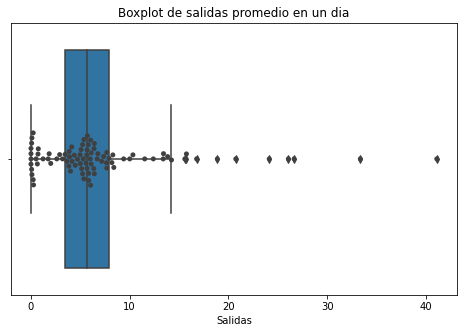

In [131]:
fig, ax = plt.subplots(figsize=(8,5))
sns.boxplot(x=prom_salidas_dia);
sns.swarmplot(x=prom_salidas_dia, color=".25");
ax.set_xlabel("Salidas")
ax.set_title("Boxplot de salidas promedio en un dia");

According to the previous boxplot, the outliers are the ones ones where there are more than 14 departures. Besides there are multiple values that are equal to zero because of the measurements that were done at very early or very late hours.

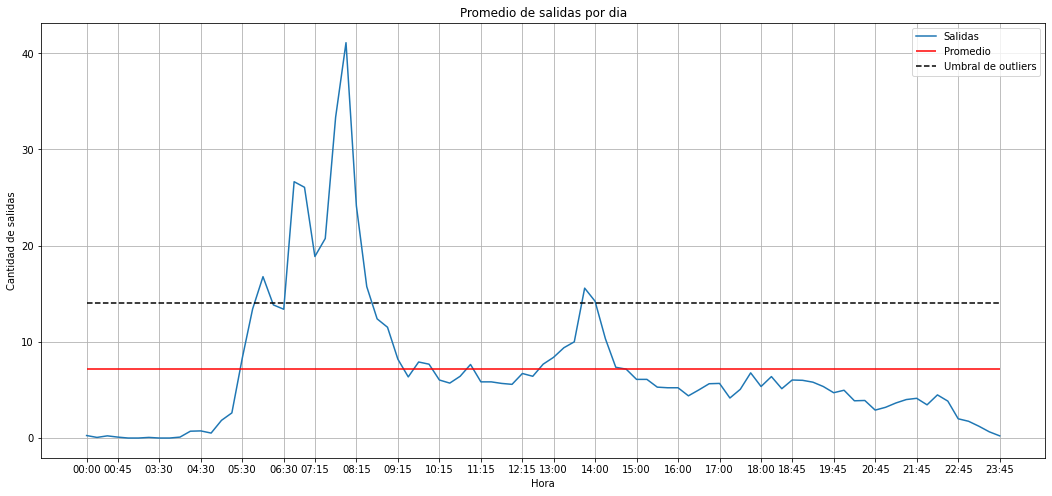

In [132]:
idx = np.linspace(0,len(df2)-1,24).astype(int)
t_labels = df2["INTERVALO"].values[idx]
dia = "Día 1"
#y = df2[dia]
y = prom_salidas_dia

fig, ax =plt.subplots(figsize=(18,8));
ax.plot(range(len(y)),y);
ax.hlines(y=y.mean(), xmin=0, xmax=len(y)-1,color="r");
ax.hlines(y=14, xmin=0, xmax=len(y)-1,color="k",linestyles="dashed");

ax.set_xticks(idx)
ax.set_xticklabels(t_labels)
ax.grid(True)
ax.set_xlabel("Hora");
ax.set_ylabel("Cantidad de salidas");
ax.set_title("Promedio de salidas por dia");
ax.legend(["Salidas","Promedio","Umbral de outliers"]);

With the previous plot we confirm that the records with more than 14 departures are outliers. In particular, notice that the largest outliers are occur during the morning rush hour from 6:00 to 8:00 am because. Besides there is another outlier between 1:30 and 2:00 pm. The cause of this high demand in the previous times of the day is probably because a lot of citizens need to use Transmilenio service to go to work or school in the morning. The peak that occurs at 2pm may be caused by multiple factors including the demand to go back home after studying or a particular need to from or to the city airport.

### Autocorrelation plots

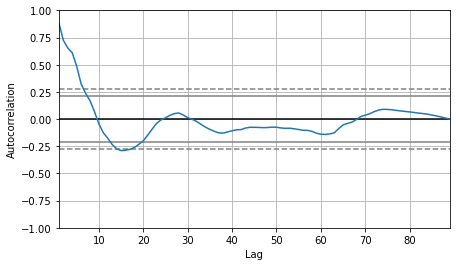

In [23]:
#  create an autocorrelation plot
plt.figure(figsize=(7,4));
autocorrelation_plot(prom_salidas_dia);
plt.grid(True);

<Figure size 864x432 with 0 Axes>

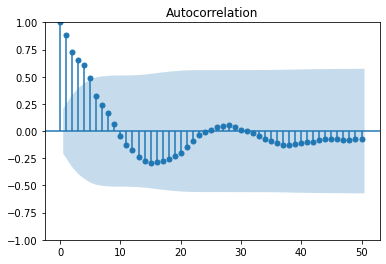

In [24]:
# autocorrelation plot of time series as a line plot
plt.figure(figsize=(12,6));
plot_acf(prom_salidas_dia, lags=50);

Parece que del primer hasta el 5to lag aproximadamente se tiene una auto correlación entre 0.25 y 0.8. Como cada intervalo es de 15 minutos (a excepción de 1 a 3 am) esto significaría que **la 1h y 15 minutos anteriores son los más relevantes para pronosticar cual va a ser la cantidad de salidas en los próximos 15 minutos**.

Ahora repitamos el mismo análisis de análisis pero para la cantidad total de salidas en una estación durante un mes específico.
Adicional a esto, realicemos una prueba de raíz unitaria con un test (aumentado) de Dickey-Fuller. El objetivo de este test es determinar si la serie de tiempo tiene alguna estructura dependiente en el tiempo.

### Análisis para una sola estación
Nuevamente para este análisis, la estación que se va a analizar es el Portal ElDorado en un mes determinado.

In [25]:
# Primero buscamos los registros del Portal ElDorado en Enero y sumamos los registros en todos los accesos
mes = "Enero"
estacion = "(06000) Portal Eldorado"
df3 = df[(df["Estación"]==estacion) & (df["Mes"]==mes)]

In [26]:
df3.head()

,Zona,Estación,Acceso de Estación,Mes,INTERVALO,Día 1,Día 2,Día 3,Día 4,Día 5,...,Día 23,Día 24,Día 25,Día 26,Día 27,Día 28,Día 29,Día 30,Día 31,Total general
0,(11) Zona K Calle 26,(06000) Portal Eldorado,(01) PLAT2 ALIM-DESAL FONTIBÓN/FONTIBÓN CENTRO...,Enero,00:00,6,0.0,10.0,29.0,7.0,...,12.0,12.0,24.0,26.0,2.0,2.0,5.0,10.0,18.0,392.0
1,(11) Zona K Calle 26,(06000) Portal Eldorado,(01) PLAT2 ALIM-DESAL FONTIBÓN/FONTIBÓN CENTRO...,Enero,00:15,10,0.0,6.0,7.0,2.0,...,8.0,2.0,7.0,1.0,0.0,10.0,9.0,4.0,3.0,152.0
2,(11) Zona K Calle 26,(06000) Portal Eldorado,(01) PLAT2 ALIM-DESAL FONTIBÓN/FONTIBÓN CENTRO...,Enero,00:30,7,0.0,1.0,0.0,8.0,...,0.0,3.0,4.0,12.0,0.0,0.0,0.0,0.0,1.0,67.0
3,(11) Zona K Calle 26,(06000) Portal Eldorado,(01) PLAT2 ALIM-DESAL FONTIBÓN/FONTIBÓN CENTRO...,Enero,00:45,3,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,30.0
4,(11) Zona K Calle 26,(06000) Portal Eldorado,(01) PLAT2 ALIM-DESAL FONTIBÓN/FONTIBÓN CENTRO...,Enero,01:00,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [27]:
df3["Acceso de Estación"].value_counts()

(01) PLAT2 ALIM-DESAL FONTIBÓN/FONTIBÓN CENTRO/VILLEMAR/CALIHAYUELOS/LAESTANCIA/ZONA FRANCA/BELÉN-TC6    89
(02) PLAT1 ALIM-ENGATIVÁ/LAFAENA/TIERRAGRATA/AEROPUERTO/ELMUELLE/AV.ELDORADO ALAMOS/VILLAAMALIA          89
(03) Acceso Peatonal Oriental                                                                            89
(04) Acceso Peatonal Occidental                                                                          89
(17) P1ALIM-ENGATIVÁ/LAFAENA/TIERRAGRATA/AEROPUERTO/ELMUELLE/AV.ELDORADOALAMOS/VILLAAMALIA(DISCAP)       89
(18) Acceso Peatonal Oriental (Discapacidad)                                                             89
(19) Acceso Peatonal Occidental (Discapacidad)                                                           89
(16) P2 A-D FONTIBÓN/FONTIBÓNCENTRO/VILLEMAR/CALIHAYUELOS/LAESTANCIA/ZONAFRANCA/BELÉN-TC6(DISCAP)        88
(24) Acceso Bicicletero                                                                                  88
CENTRO                      

In [28]:
# Primero validemo por que algunos accesos tienen 89 registros y otros 88
# Comparemos los intervalos entre el acceso (17) y el acceso CENTRO
df3_1 = df3[df3["Acceso de Estación"].str.contains("(17)")]
df3_2 = df3[df3["Acceso de Estación"]=="CENTRO"]

C:\Users\juanc\AppData\Local\Temp\ipykernel_11056\2951096830.py:3: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df3_1 = df3[df3["Acceso de Estación"].str.contains("(17)")]


In [29]:
list(df3_1["INTERVALO"])

['00:00',
 '00:15',
 '00:30',
 '00:45',
 '01:00',
 '03:00',
 '03:15',
 '03:30',
 '03:45',
 '04:00',
 '04:15',
 '04:30',
 '04:45',
 '05:00',
 '05:15',
 '05:30',
 '05:45',
 '06:00',
 '06:15',
 '06:30',
 '06:45',
 '07:00',
 '07:15',
 '07:30',
 '07:45',
 '08:00',
 '08:15',
 '08:30',
 '08:45',
 '09:00',
 '09:15',
 '09:30',
 '09:45',
 '10:00',
 '10:15',
 '10:30',
 '10:45',
 '11:00',
 '11:15',
 '11:30',
 '11:45',
 '12:00',
 '12:15',
 '12:30',
 '12:45',
 '13:00',
 '13:15',
 '13:30',
 '13:45',
 '14:00',
 '14:15',
 '14:30',
 '14:45',
 '15:00',
 '15:15',
 '15:30',
 '15:45',
 '16:00',
 '16:15',
 '16:30',
 '16:45',
 '17:00',
 '17:15',
 '17:30',
 '17:45',
 '18:00',
 '18:15',
 '18:30',
 '18:45',
 '19:00',
 '19:15',
 '19:30',
 '19:45',
 '20:00',
 '20:15',
 '20:30',
 '20:45',
 '21:00',
 '21:15',
 '21:30',
 '21:45',
 '22:00',
 '22:15',
 '22:30',
 '22:45',
 '23:00',
 '23:15',
 '23:30',
 '23:45']

In [30]:
list(df3_2["INTERVALO"])

['00:00',
 '00:15',
 '00:30',
 '00:45',
 '03:00',
 '03:15',
 '03:30',
 '03:45',
 '04:00',
 '04:15',
 '04:30',
 '04:45',
 '05:00',
 '05:15',
 '05:30',
 '05:45',
 '06:00',
 '06:15',
 '06:30',
 '06:45',
 '07:00',
 '07:15',
 '07:30',
 '07:45',
 '08:00',
 '08:15',
 '08:30',
 '08:45',
 '09:00',
 '09:15',
 '09:30',
 '09:45',
 '10:00',
 '10:15',
 '10:30',
 '10:45',
 '11:00',
 '11:15',
 '11:30',
 '11:45',
 '12:00',
 '12:15',
 '12:30',
 '12:45',
 '13:00',
 '13:15',
 '13:30',
 '13:45',
 '14:00',
 '14:15',
 '14:30',
 '14:45',
 '15:00',
 '15:15',
 '15:30',
 '15:45',
 '16:00',
 '16:15',
 '16:30',
 '16:45',
 '17:00',
 '17:15',
 '17:30',
 '17:45',
 '18:00',
 '18:15',
 '18:30',
 '18:45',
 '19:00',
 '19:15',
 '19:30',
 '19:45',
 '20:00',
 '20:15',
 '20:30',
 '20:45',
 '21:00',
 '21:15',
 '21:30',
 '21:45',
 '22:00',
 '22:15',
 '22:30',
 '22:45',
 '23:00',
 '23:15',
 '23:30',
 '23:45']

El registro de 1 am no está para el acceso de la estación 'CENTRO'. Aunque es un valor que no tiene mucha relevancia porque a esa hora ya no debería haber actividad, por rigurosidad sería bueno insertar ese registro con valor igual a 0 o igual al promedio de los valores vecinos para que todos los accesos tengan 89 registros.Adicionalmente, se debería hacer una verificación de que en los otros accesos el valor que falta sea a la misma hora, pero el método de corrección es análogo.

Para hacer un análisis más rápido se considerará los accesos con todos los 89 registros.

In [31]:
df_pED = df3[df3["Acceso de Estación"].str.contains("(17)|(02)|(18)|(03)|(19)|(04)|(01)")]
df_pED = df_pED.astype({"Día 30":float, "Día 31":float})

C:\Users\juanc\AppData\Local\Temp\ipykernel_11056\1530888615.py:1: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df_pED = df3[df3["Acceso de Estación"].str.contains("(17)|(02)|(18)|(03)|(19)|(04)|(01)")]


In [32]:
accesos = set(df_pED["Acceso de Estación"].values)
salidas_totales = np.zeros(89*31)
for acc in accesos:
    df_aux = df_pED[df_pED["Acceso de Estación"]==acc]
    for i in range(1,32):
        salidas_totales[(i-1)*89:i*89] += df_aux["Día "+str(i)]
#    salidas_totales += df_pED["Total general"].values[89*i:89*(i+1)]
salidas_totales = salidas_totales.astype(int)

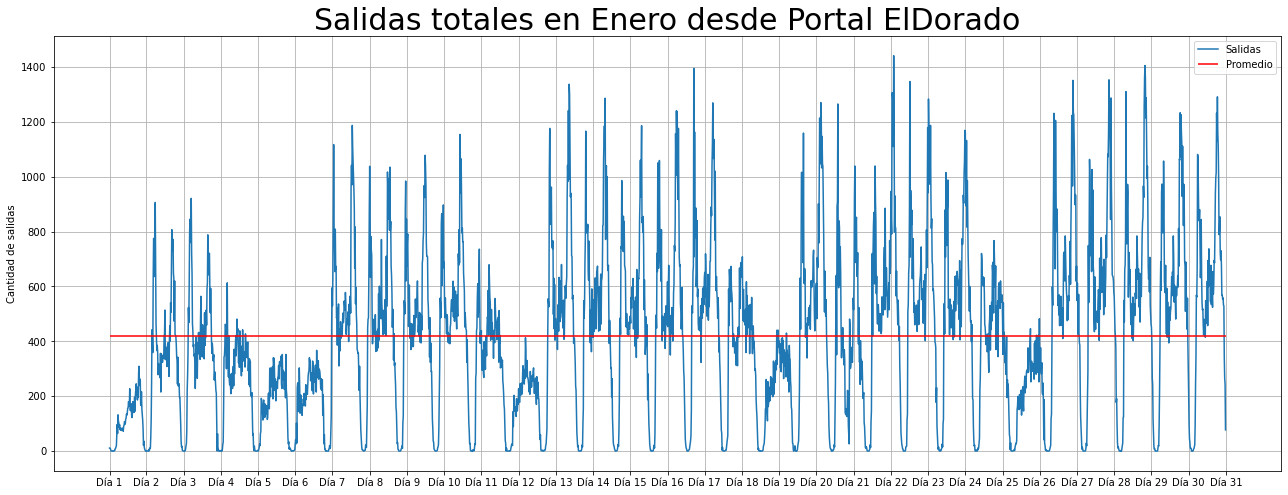

In [33]:
idx = np.linspace(0,89*31,31).astype(int)
t_labels = ["Día "+str(i) for i in range(1,32)]
y = salidas_totales;

fig, ax =plt.subplots(figsize=(22,8));
ax.plot(range(len(y)),y);
ax.hlines(y=y.mean(), xmin=0, xmax=len(y)-1,color="r");

ax.set_xticks(idx)
ax.set_xticklabels(t_labels)
ax.grid(True)
ax.set_ylabel("Cantidad de salidas");
ax.set_title("Salidas totales en Enero desde Portal ElDorado", fontsize=30);
ax.legend(["Salidas","Promedio"]);

In [34]:
print(y.mean())

417.5762957593331


- **En todo el mes:** el promedio de salidas En el portal Eldorado en enero es de 417. Claramente hay un ciclo semanal con picos por día. Aunque en la primera semana parece que el nivel (promedio es más pequeño que el resto de las semanas).
- **Por semana:** los días entre semana suelen tener valores más altos de salidas mientras, los sábados un poco menos y el domingo es el día con cantidad de salidas más bajo, a excepción del primer día (1ero de enero) ya que es festivo y probablemente la gente casi no se mueve por ser festivo después de fin de año o porque están afuera de la ciudad. Suele haber 2 picos por día con un comportamiento con un pico alrededor del medio día no tan alto como los dos que se encuentran al comienzo y final de cada día.
- **Por día**: Adicionalmente a los picos también puede haber patrones inusuales con mínimos como se ve para el 21 de enero. En ese caso, la cantidad baja de salidas se debe a que ese día se declaró paro nacional por lo cual hubo muy pocas personas que utilizaron el Transmilenio ese día.
**Conclusiones** : Los patrones por semana son muy similares por lo cual es mejor hacer un **análisis a escala semanal**. Del mismo modo vale la pena **analizar patrones a escala diaria**. También se podría analizar patrones para días específicos de la semana.

Tomemos de ejemplo la 3era semana de Enero

In [35]:
# TERMINAR FUNCION PARA ACCESOS EN PLATAFORMA CON VALORES DISTINTOS A 89 REGISTROS O COLUMNAS CON X EN Día 30/31
def get_station_data(estacion,mes,dia1=1,dia2=31):
    """
    Consigue la suma de todas las salidas en una estacion en un determinado mes entre 2 fechas especificas de ese mes
    
    args:
        estacion: nombre de la estacion
        mes: string del nombre del mes en el que se quiere conseguir los datos
        dia1: string del dia limite inferior incluido
        dia2: string del dia limite inferior incluido
        
    returns:
        arreglo con valores entre las fechas especificadas
    """
    # Primer filtro del nombre de la estacion y mes de interes
    df_aux = df[(df["Estación"]==estacion) & (df["Mes"]==mes)]
    df_aux = df_aux.astype({"Día 30":float, "Día 31":float})
    val_counts = df_aux["Acceso de Estación"].value_counts()
    # Conseguimos todos los nombres de accesos donde haya 89 registros por dia
    valid_access = df_aux["Acceso de Estación"].value_counts().index[np.where(val_counts==89)]
    salidas_totales = np.zeros(89*(dia2-(dia1-1))) # Asumiendo que el formato de los datos es correcto en los 31 dias
    for acc in valid_access:
        # Busqueda de los registros por acceso de la estacion
        df_aux_2 = df_aux[df_aux["Acceso de Estación"]==acc]
        #print(df_aux_2.shape)
        c=0
        for i in range(dia1,dia2+1):
            salidas_totales[c*89:(c+1)*89] += df_aux_2["Día "+str(i)]
            c+=1
    salidas_totales = salidas_totales.astype(int)
    return salidas_totales

In [36]:
d1=13
d2=18
m="Enero"
estacion = "(03000) Portal Suba"
salidas = get_station_data(estacion, mes=m,dia1=d1,dia2=d2)
idx = np.linspace(0,89*(d2-(d1-1)),d2-(d1-1)).astype(int)
t_labels = ["Día "+str(i) for i in range(d1,d2+1)]

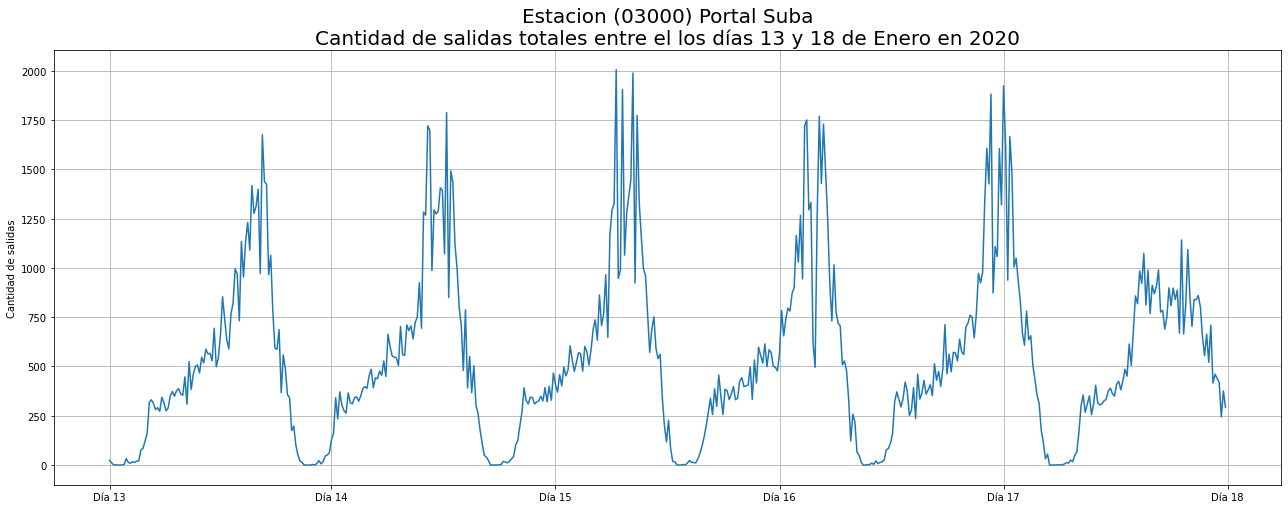

In [37]:
fig, ax =plt.subplots(figsize=(22,8));
ax.plot(range(len(salidas)),salidas);
#ax.hlines(y=y.mean(), xmin=0, xmax=len(y)-1,color="r");

ax.set_xticks(idx)
ax.set_xticklabels(t_labels)
ax.grid(True)
ax.set_ylabel("Cantidad de salidas");
ax.set_title("Estacion " +estacion + "\nCantidad de salidas totales entre el los días "+str(d1) + " y "+str(d2)+" de "+m + " en 2020",fontsize=20);
#ax.legend(["Salidas","Promedio"]);

In [38]:
result = seasonal_decompose(salidas, model='additive', period=89)

In [39]:
def plot_decomposition(res,idx,t_labels):
    """
    Grafica la descomposición de una serie de tiempo
    
    args:
        res: serie de tiempo con los resultados de la descomposición.
    """
    # Observed
    fig,ax = plt.subplots(4,1,figsize=(15,10));
    ax[0].grid(True)
    ax[0].plot(res.observed);
    ax[0].set_title("Observed");
    
    # Trend
    ax[1].grid(True)
    ax[1].plot(res.trend);
    ax[1].set_title("Trend");
    
    # Seasonal
    ax[2].grid(True)
    ax[2].plot(res.seasonal);
    ax[2].set_title("Seasonal");
    
    # Residual
    ax[3].grid(True)
    ax[3].plot(res.resid);
    ax[3].set_title("Residual");
    
    ax[0].set_xticks(idx);
    ax[0].set_xticklabels(t_labels);
    ax[1].set_xticks(idx);
    ax[1].set_xticklabels(t_labels);
    ax[2].set_xticks(idx);
    ax[2].set_xticklabels(t_labels);
    ax[3].set_xticks(idx);
    ax[3].set_xticklabels(t_labels);

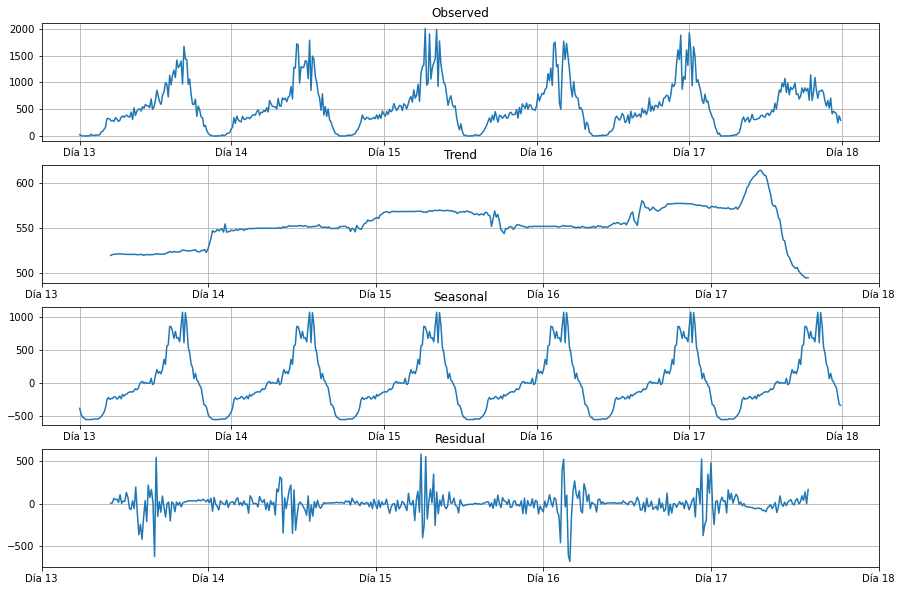

In [40]:
plot_decomposition(result,idx,t_labels)

Text(0.5, 1.0, 'histograma de frecuencias')

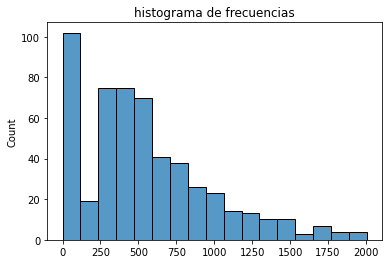

In [41]:
#plt.hist(salidas,bins=12);
sns.histplot(salidas);
plt.title("histograma de frecuencias")

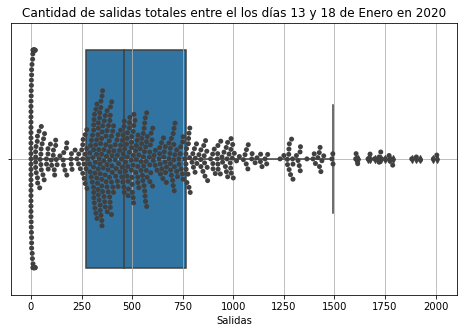

In [42]:
fig, ax = plt.subplots(figsize=(8,5))
sns.boxplot(x=salidas);
sns.swarmplot(x=salidas, color=".25");
ax.set_xlabel("Salidas")
ax.grid(True);
ax.set_title("Cantidad de salidas totales entre el los días "+str(d1) + " y "+str(d2)+" de "+m + " en 2020");

In [43]:
salidas[(salidas>1500)]

array([1676, 1721, 1698, 1788, 2006, 1905, 1989, 1774, 1721, 1751, 1770,
       1729, 1607, 1882, 1605, 1925, 1615, 1666])

Hay muchos valores en 0 por las primeras y últimas horas del día. Los valores entre el cuartil 1 y el cuartil 3 están entre 270 y 520 aproximadamente. Hay una cola larga entre el cuartil 3 y el 4 (1500 salidas) debido a que hay una gran cantidad de valores en ese rango. Por último, los valores superiores a 1500 salidas parecen ser outliers, respectivamente los máximos asociados a las horas picos con salidas máximas.

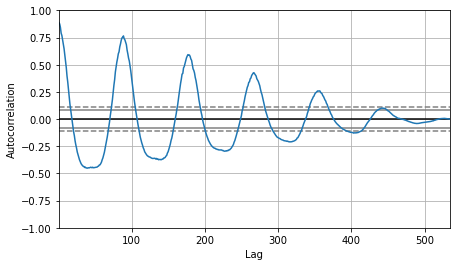

In [44]:
plt.figure(figsize=(7,4));
autocorrelation_plot(salidas);
plt.grid(True);

**NOTA: Como regla, la PACF define el orden de AR(p) y la ACF el orden de MA(q)**

<Figure size 864x432 with 0 Axes>

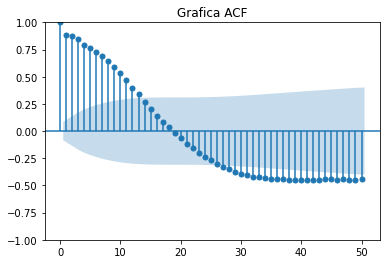

In [45]:
plt.figure(figsize=(12,6));
plot_acf(salidas, lags=50);
plt.title("Grafica ACF"); # Para MA(q)

C:\Users\juanc\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


<Figure size 864x432 with 0 Axes>

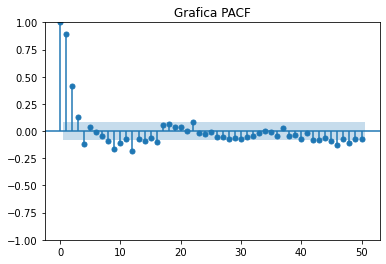

In [46]:
plt.figure(figsize=(12,6));
plot_pacf(salidas, lags=50);
plt.title("Grafica PACF"); # Para AR(p)

## Test Aumentado de Dickey-Fuller
- Hipótesis nula: La serie tiene raíz unitaria, serie no es estacionaria, por lo tanto, dificultades para estimaciones.
- Hipótesis alternativa:(con p-valor menor a valores críticos) la serie no tiene raíz unitaria. Entre más negativo el estadistico ADF más se rechaza la hipótesis.

La presencia de raíz unitaria nos hace creer un estimador es significante (bueno) para la regresión cuando en realidad no lo es.

**Wikipedia:**

En estadística y econometría, una prueba de Dickey-Fuller aumentada (ADF) es una prueba de raíz unitaria para una muestra de una serie de tiempo. Es una versión aumentada de la prueba Dickey-Fuller para un conjunto más amplio y más complejo de modelos de series de tiempo. La estadística Dickey-Fuller Aumentada (ADF), utilizada en la prueba, es un número negativo. Cuanto más negativo es, más fuerte es el rechazo de la hipótesis nula de que existe una raíz unitaria para un cierto nivel de confianza.

**Mejor explicacion en:** https://www.analyticsvidhya.com/blog/2015/12/complete-tutorial-time-series-modeling/

In [47]:
X = salidas
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -5.500718
p-value: 0.000002
Critical Values:
	1%: -3.443
	5%: -2.867
	10%: -2.570


Se rechaza la hipótesis nula, por lo tanto no hay raíz unitaria, la serie es estacionaria.

### Estimacion de salidas
Se estimará las salidas con distintos modelos de series de tiempo incluidos redes neuronales recurrentes (RNN).
Los datos que se quieren pronosticar vienen de la suma de salidas de la estacion "(03000) Portal Suba".
- Cantidad de datos de serie: 534, 89 por día (lunes a sabado)

Cantidad de datos: 534


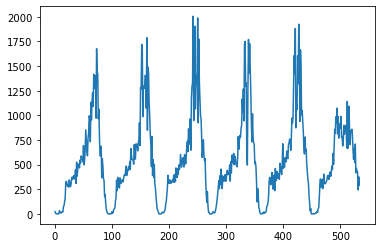

In [48]:
# Grafica de comportamiento de la serie
print("Cantidad de datos:", len(X))
plt.plot(X);

- Mejor grado de MA(q) = 14
- Mejor grado de modelo AR = 2 (explorar con 3 la diferencia)
- Parametro s de modelo SARIMA: Cantidad de puntos por ciclo

Dado que el modelo tiene un ciclo y la serie es estacionaria conviene utilizar un modelo SARIMA.

In [49]:
# Separacion datos de entrenamiento y de prueba
X_train =  X[:4 * int(len(X)/6.0)] # Exog
X_test = X[4 * int(len(X)/6.0):] # Endog

In [50]:
X_test.shape

(178,)

## 2. Agrupamiento de Series
- Conseguir información de todas las salidas por estación y agruparlas en un solo dataset (Todas van a tener la misma cantidad de datos).
- Aplicar agrupación jerárquica

In [51]:
# Primero conseguir el nombre de todas las estaciones de transmilenio
# Luego se itera sobre cada estacion y se consigue la cantidad de salidas en el mes e intervalo de salidas especificado
# Se concatena todos los arreglos en un dataframe
estaciones = list(set(df["Estación"]))
print("Cantidad de estaciones: ",len(estaciones))
# Informacion para query
d1=13
d2=18
m="Enero"
#salidas = get_station_data("(03000) Portal Suba",mes=m,dia1=d1,dia2=d2)
idx = np.linspace(0,89*(d2-(d1-1)),d2-(d1-1)).astype(int)
t_labels = ["Día "+str(i) for i in range(d1,d2+1)]
mat = []
for e in estaciones:
    s = get_station_data(e,mes=m,dia1=d1,dia2=d2)
    mat.append(s.reshape([len(s),1]))


Cantidad de estaciones:  159


In [52]:
df_salidas_estacion = pd.DataFrame(np.concatenate(mat,axis=1),columns=estaciones)
df_salidas_estacion.head()

,(09105) Río Fucha,(09110) Avenida Jimenez,(07003) SEVILLANA,(03011) SUBA - CALLE 100,(05103) Marsella,(02202) Calle 127,(07111) NQS - RICAURTE,(02502) Terminal,(09113) Calle 22,(06111) Universidades,...,(10004) Policarpa,(03009) Av. Suba- Calle 116,(07101) CASTELLANA,(08000) Portal Tunal,(12003) Ricaurte,(10001) Country Sur,(07503) SAN MATEO,(04108) El Polo,(09000) Cabecera Usme,(07112) COMUNEROS
0,0,0,1,1,0,0,0,3,1,0,...,0,3,0,5,0,1,2,0,19,2
1,1,0,1,0,0,1,2,0,0,1,...,0,2,0,22,0,1,1,0,7,0
2,0,0,1,0,0,0,0,3,0,0,...,3,1,0,28,0,0,1,1,0,0
3,0,4,1,0,1,1,1,1,0,0,...,0,1,0,17,0,2,1,1,7,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


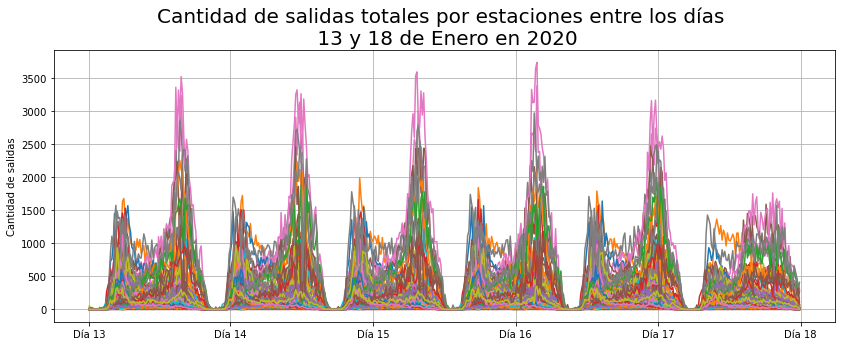

In [53]:
# Grafica de toda la cantidad de salidas por estacion
fig, ax =plt.subplots(figsize=(14,5));
ax.plot(range(len(df_salidas_estacion)),df_salidas_estacion.values);

ax.set_xticks(idx)
ax.set_xticklabels(t_labels)
ax.grid(True)
ax.set_ylabel("Cantidad de salidas");
ax.set_title("Cantidad de salidas totales por estaciones entre los días \n "+str(d1) + " y "+str(d2)+" de "+m + " en 2020",\
             fontsize=20);
#ax.legend(estaciones[:10]);

El agrupamiento de series se hace con **Dynamic Time Warping** (DTW).

In [54]:
df_salidas_estacion.isna().sum()

(09105) Río Fucha           0
(09110) Avenida Jimenez     0
(07003) SEVILLANA           0
(03011) SUBA - CALLE 100    0
(05103) Marsella            0
                           ..
(10001) Country Sur         0
(07503) SAN MATEO           0
(04108) El Polo             0
(09000) Cabecera Usme       0
(07112) COMUNEROS           0
Length: 159, dtype: int64

In [55]:
# Filtremos las columnas que son 0.
# Algunas no tienen valores quizas porque se excluyeron los accesos
# en los que habia menos de 89 registros al dia y puede que en esos si hubiera datos 
estaciones_z = [df_salidas_estacion.columns[i] for i in range(df_salidas_estacion.shape[1]) if np.all(df_salidas_estacion.iloc[:,i]==0)]
# Eliminamos estas estaciones (no deberia hacerse para conservar datos, por ahora si)
df_salidas_estacion = df_salidas_estacion.drop(columns=estaciones_z)
df_salidas_estacion.shape

(534, 156)

In [56]:
# Con la columna 11 hay nans
distance_matrix = df_salidas_estacion.corr()

In [57]:
from scipy.cluster.hierarchy import single, complete, average, ward, dendrogram

In [58]:
def hierarchical_clustering(dist_mat, method='complete'):
    if method == 'complete':
        Z = complete(distance_matrix)
    if method == 'single':
        Z = single(distance_matrix)
    if method == 'average':
        Z = average(distance_matrix)
    if method == 'ward':
        Z = ward(distance_matrix)
    
    fig = plt.figure(figsize=(16, 8))
    dn = dendrogram(Z)
    plt.title(f"Dendrogram for {method}-linkage with correlation distance")
    plt.show()
    
    return Z

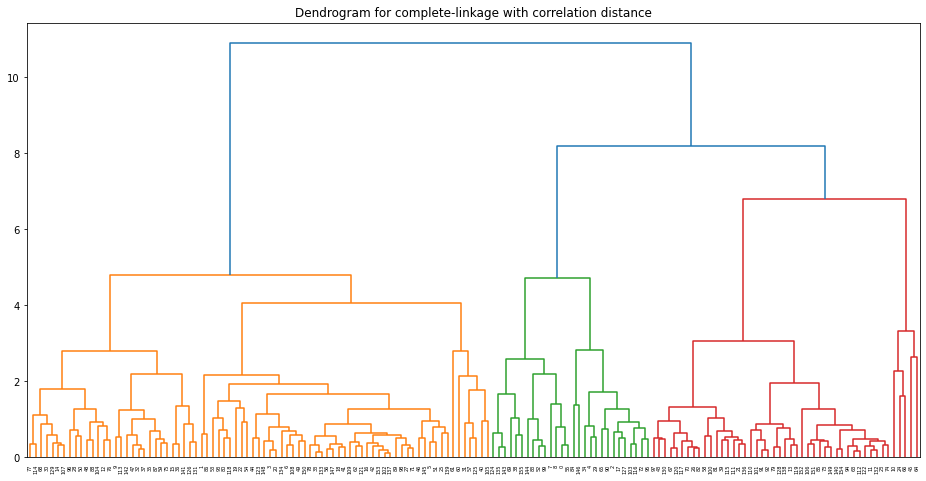

In [59]:
linkage_matrix = hierarchical_clustering(distance_matrix)

In [60]:
from scipy.cluster.hierarchy import fcluster
# hand-select an appropriate cut-off on the dendrogram
cluster_labels = fcluster(linkage_matrix, 7.5, criterion='distance')
print(np.unique(cluster_labels))

[1 2 3]


In [61]:
clusters = dict()
for i in np.unique(cluster_labels):
    clusters[i] = df_salidas_estacion.columns[cluster_labels==i]

In [62]:
print("Cluster 1:")
print(clusters[1])
print("==========================================")

print("Cluster 2:")
print(clusters[2])
print("==========================================")

print("Cluster 3:")
print(clusters[3])

Cluster 1:
Index(['(09110) Avenida Jimenez', '(03011) SUBA - CALLE 100',
       '(02202) Calle 127', '(07111) NQS - RICAURTE', '(06111) Universidades',
       '(04105) Carrera 53', '(07201) Guatoque -Veraguas',
       '(06102) Salitre El Greco', '(02205) Calle 106',
       '(10009) Museo Nacional', '(02204) Pepe Sierra',
       '(07102) NQS - CALLE 75', '(03014) SAN MARTIN',
       '(05107) Américas - Cr.53', '(07107) U. NACIONAL', '(09107) Hortúa',
       '(07106) EL CAMPIN', '(09114) Calle 26', '(09117) Calle 45',
       '(09115) Calle 34', '(09118) Marly', '(14001) La Sabana',
       '(09120) Calle 63', '(02300) Calle 100', '(06103) CAN',
       '(07108) Av. El Dorado', '(14004) Museo del Oro', '(05105) Pradera',
       '(09119) Calle 57', '(02201) Prado', '(07104) Simon Bolivar',
       '(10010) San Bernardo', '(09122) Calle 72', '(12002) CDS - Carrera 32',
       '(12001) Carrera 43', '(07103) AV. CHILE', '(02303) Calle 85',
       '(06109) Centro Memoria', '(08002) Biblioteca',
 

In [63]:
# Grafiquemos las series de cada cluster
cluster_estaciones_1 = df_salidas_estacion[clusters[1]]
cluster_estaciones_2 = df_salidas_estacion[clusters[2]]
cluster_estaciones_3 = df_salidas_estacion[clusters[3]]

[Text(0, 0, 'Día 13'),
 Text(106, 0, 'Día 14'),
 Text(213, 0, 'Día 15'),
 Text(320, 0, 'Día 16'),
 Text(427, 0, 'Día 17'),
 Text(534, 0, 'Día 18')]

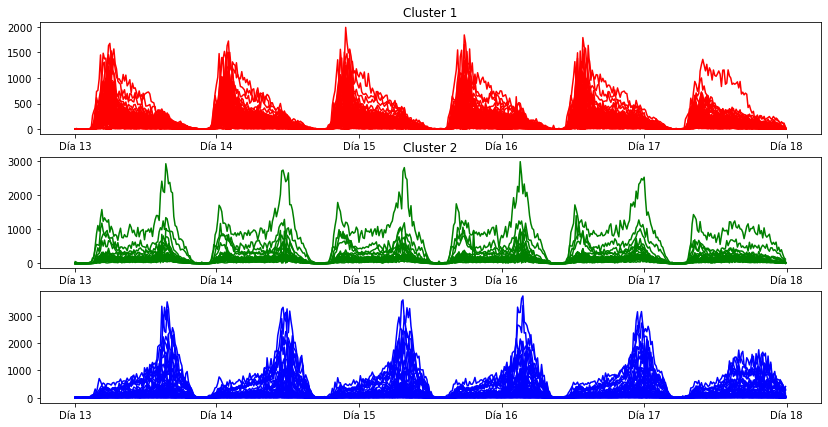

In [64]:
fig, ax = plt.subplots(3,1,figsize=(14,7))

ax[0].plot(cluster_estaciones_1,color="r");
ax[0].set_title("Cluster 1");
ax[0].set_xticks(idx)
ax[0].set_xticklabels(t_labels)

ax[1].plot(cluster_estaciones_2,color="g");
ax[1].set_title("Cluster 2");
ax[1].set_xticks(idx)
ax[1].set_xticklabels(t_labels)


ax[2].plot(cluster_estaciones_3,color="b");
ax[2].set_title("Cluster 3");
ax[2].set_xticks(idx)
ax[2].set_xticklabels(t_labels)


## Ubicando información de estaciones geograficamente

In [65]:
def get_station_codes(df):
    codigos = []
    for col in df.columns:
        left_p = False
        right_p = False
        cod = ""
        for i in range(len(col)):
            if col[i]=='(':
                left_p = True
                j = i+1
                while not right_p:
                    cod += col[j]
                    j+=1
                    if col[j] == ')':
                        right_p = True
            break
        codigos.append(cod)
    return codigos  

In [66]:
codigos_estaciones = get_station_codes(df_salidas_estacion)
#codigos_estaciones

In [67]:
path_to_data_bog = "dscat_shp\\scat_shp\\scat.shp"
gdf_bog = gpd.read_file(path_to_data_bog)

In [68]:
path_estaciones = "GTFS-2020-01-24\\stops.txt"
df_estaciones = pd.read_csv(path_estaciones,encoding='latin-1', header=0)
print(df_estaciones.shape)
df_estaciones.head()

(7793, 4)


,stop_id,stop_name,stop_lat,stop_lon
0,09121,Flores,4.654713,-74.063088
1,06106,Corferias,4.634100,-74.089203
2,07504,Terreros - Hospital C.V.,4.590032,-74.197525
3,09103,Olaya,4.578931,-74.107294
4,09101,Quiroga,4.576762,-74.114240


In [69]:
# Busqueda de las estaciones si su codigo coincide con el codigo de las salidas
filas_est_TM = [np.where(df_estaciones["stop_id"]==codigos_estaciones[i]) for i in range(len(codigos_estaciones))]
filas_TM = [arr[0][0] for arr in filas_est_TM if len(arr[0]) != 0]
df_estaciones = df_estaciones.iloc[filas_TM,:]

In [70]:
df_estaciones.columns

Index(['stop_id', 'stop_name', 'stop_lat', 'stop_lon'], dtype='object')

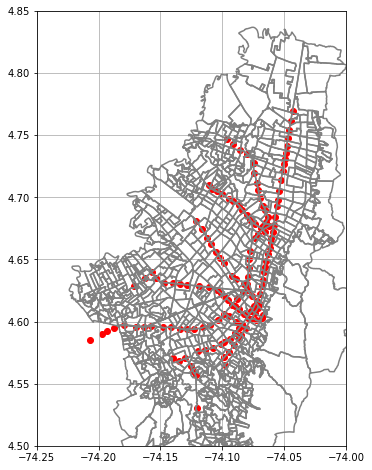

In [71]:
ax = gdf_bog.boundary.plot(figsize=(8,8),color="gray");
minx, miny, maxx, maxy = [-74.25, 4.5, -74, 4.85]
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)
ax.scatter(df_estaciones["stop_lon"],df_estaciones["stop_lat"],color="r");
plt.grid(True);

**Pintemos las estaciones por cluster**.

Busquemos el id de las estaciones en el cluster 1

In [72]:
print(df_estaciones['stop_id'].values[0])

df_estaciones['stop_id'][128]

09105


'07006'

In [73]:
# Buscar para cada id de df_estaciones en cual cluster esta
ids_c1 = get_station_codes(cluster_estaciones_1)
ids_c2 = get_station_codes(cluster_estaciones_2)
ids_c3 = get_station_codes(cluster_estaciones_3)

etiquetas = np.zeros(df_estaciones.shape[0])
for i in range(df_estaciones.shape[0]):
    if df_estaciones['stop_id'].values[i] in ids_c1:
        etiquetas[i] = 1
    elif df_estaciones['stop_id'].values[i] in ids_c2:
        etiquetas[i] = 2
    elif df_estaciones['stop_id'].values[i] in ids_c3:
        etiquetas[i] = 3
    else:
        etiquetas[i] = None

In [74]:
df_estaciones["cluster"] = etiquetas

### Grafica de estaciones por cluster

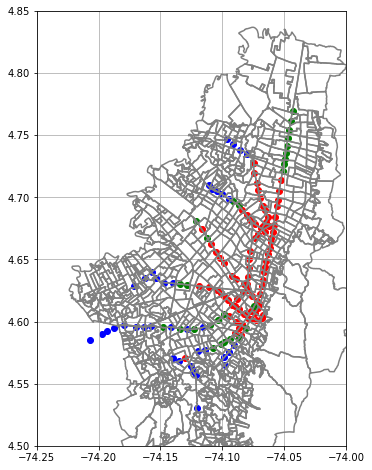

In [75]:
ax = gdf_bog.boundary.plot(figsize=(8,8),color="gray");
minx, miny, maxx, maxy = [-74.25, 4.5, -74, 4.85]
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)
ax.scatter(df_estaciones.loc[df_estaciones["cluster"]==1,"stop_lon"],df_estaciones.loc[df_estaciones["cluster"]==1,"stop_lat"],color="r");
ax.scatter(df_estaciones.loc[df_estaciones["cluster"]==2,"stop_lon"],df_estaciones.loc[df_estaciones["cluster"]==2,"stop_lat"],color="g");
ax.scatter(df_estaciones.loc[df_estaciones["cluster"]==3,"stop_lon"],df_estaciones.loc[df_estaciones["cluster"]==3,"stop_lat"],color="b");
plt.grid(True);

[Text(0, 0, 'Día 13'),
 Text(106, 0, 'Día 14'),
 Text(213, 0, 'Día 15'),
 Text(320, 0, 'Día 16'),
 Text(427, 0, 'Día 17'),
 Text(534, 0, 'Día 18')]

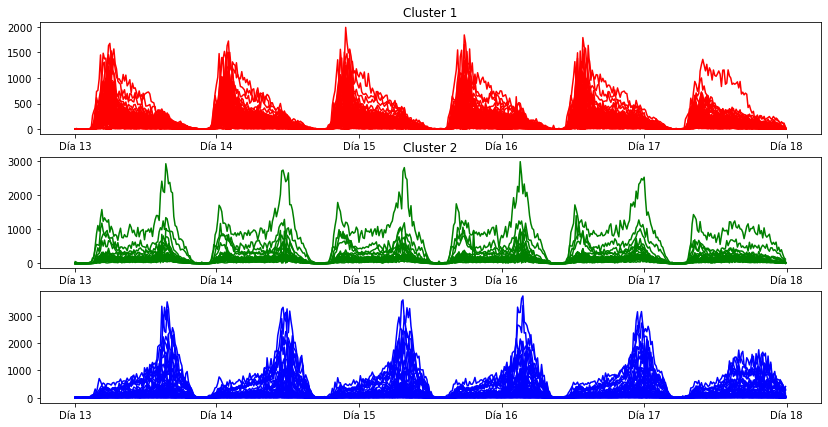

In [76]:
fig, ax = plt.subplots(3,1,figsize=(14,7))

ax[0].plot(cluster_estaciones_1,color="r");
ax[0].set_title("Cluster 1");
ax[0].set_xticks(idx)
ax[0].set_xticklabels(t_labels)

ax[1].plot(cluster_estaciones_2,color="g");
ax[1].set_title("Cluster 2");
ax[1].set_xticks(idx)
ax[1].set_xticklabels(t_labels)


ax[2].plot(cluster_estaciones_3,color="b");
ax[2].set_title("Cluster 3");
ax[2].set_xticks(idx)
ax[2].set_xticklabels(t_labels)


## Dibujo de Bogotá

In [77]:
import requests
import shapely
from shapely.geometry import shape, Point, Polygon

In [78]:
#url = 'http://polygons.openstreetmap.fr/get_geojson.py?id=12893646&params=0'
url = './bogota_geojson.geojson'
geo_dict = gpd.read_file(url)

In [79]:
geo_dict.head()

,geometry
0,GEOMETRYCOLLECTION (MULTIPOLYGON (((-74.44214 ...


In [80]:
import json
  
# Opening JSON file
f = open(url)
  
# returns JSON object as 
# a dictionary
data = json.load(f)
f.close()

In [81]:
# Lista de parejas de puntos
points = data['geometries'][0]['coordinates'][0][0]

In [82]:
df = pd.DataFrame(
    {
        'ID': ["p"+str(i) for i in range(len(points))],
        'Latitud': [p[0] for p in points],
        'Longitud': [p[1] for p in points]
    })

In [83]:
# Creacion de geodataframe a partir de columnas con coordenadas x,y
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.Latitud, df.Longitud))
gdf = gdf.set_crs('epsg:4326')
gdf.head()

,ID,Latitud,Longitud,geometry
0,p0,-74.442138,3.732709,POINT (-74.44214 3.73271)
1,p1,-74.441395,3.731875,POINT (-74.44139 3.73187)
2,p2,-74.441153,3.731252,POINT (-74.44115 3.73125)
3,p3,-74.440969,3.730652,POINT (-74.44097 3.73065)
4,p4,-74.441061,3.730209,POINT (-74.44106 3.73021)


In [84]:
# Creando objeto poligono
bogotaPolygon = Polygon(points)

In [85]:
gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [86]:
# Separacion en diccionario de estaciones por cluster
df_clusters = {}
for i in range(1,4):
    df_clusters[i] = df_estaciones.loc[df_estaciones["cluster"]==i,:]

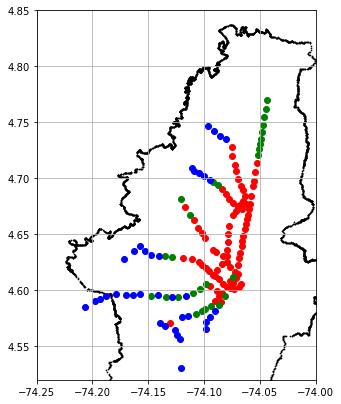

In [87]:
# Gráfica de Bogota
fig, ax = plt.subplots(figsize = (5,7))
ax = gdf.to_crs(epsg=4326).plot(ax=ax, color='lightgrey', edgecolor='black', markersize=0.5)

# Grafica de estaciones
minx, miny, maxx, maxy = [-74.25, 4.52, -74, 4.85]
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)



# Scatter de clusters
ax.scatter(df_estaciones.loc[df_estaciones["cluster"]==1,"stop_lon"],
           df_estaciones.loc[df_estaciones["cluster"]==1,"stop_lat"],color="r");
ax.scatter(df_estaciones.loc[df_estaciones["cluster"]==2,"stop_lon"],
           df_estaciones.loc[df_estaciones["cluster"]==2,"stop_lat"],color="g");
ax.scatter(df_estaciones.loc[df_estaciones["cluster"]==3,"stop_lon"],
           df_estaciones.loc[df_estaciones["cluster"]==3,"stop_lat"],color="b");

ax.grid(True);

## Dibujo de  evolucion de tamaño de estaciones en un periodo
- **Opción 1:** establecer un tamaño mínimo que represente 0 salidas en la estación y un tamaño máximo para el máximo número de salidas en un periodo determinado sin que se solapen demasiado los puntos.
- **Opción 2:** colorear los puntos acorde a una escala de colores, mostrar en paralelo la ubicación de las estaciones por cluster

# Opción 1

1. Definir un periodo en el cual se muestra la animación: un dia, un fin de semana
2. Extraer la cantidad de salidas para el periodo elegido
3. Crear funcion que a partir de una cantidad de salidas retorna un tamaño normalizado del punto
4. Aplicar la función a cada uno de los valores del periodo elegido
5. Crear animación con un bucle

Nuevamente lectura de datos iniciales

In [88]:
salidas = pd.read_csv("consolidado-de-salidas-sistema-troncal-por-franja-horaria-enero-abril-2020.csv",
                 encoding='latin-1', header=0,sep=';')

C:\Users\juanc\AppData\Local\Temp\ipykernel_11056\1251618856.py:1: DtypeWarning: Columns (34,35) have mixed types. Specify dtype option on import or set low_memory=False.
  salidas = pd.read_csv("consolidado-de-salidas-sistema-troncal-por-franja-horaria-enero-abril-2020.csv",


In [89]:
salidas = salidas.drop(columns=["Unnamed: 37","Unnamed: 38"])

In [90]:
salidas.columns

Index(['Zona', 'Estación', 'Acceso de Estación', 'Mes', 'INTERVALO', 'Día 1',
       'Día 2', 'Día 3', 'Día 4', 'Día 5', 'Día 6', 'Día 7', 'Día 8', 'Día 9',
       'Día 10', 'Día 11', 'Día 12', 'Día 13', 'Día 14', 'Día 15', 'Día 16',
       'Día 17', 'Día 18', 'Día 19', 'Día 20', 'Día 21', 'Día 22', 'Día 23',
       'Día 24', 'Día 25', 'Día 26', 'Día 27', 'Día 28', 'Día 29', 'Día 30',
       'Día 31', 'Total general'],
      dtype='object')

En un dia hay 37 puntos. Recuperemos los datos en un solo dia

In [91]:
# 1. Definir un periodo en el cual se muestra la animación: un dia, un fin de semana
diasMes = ['Día 2']
mes = 'Enero'
cols = ['Zona', 'Estación', 'Acceso de Estación', 'Mes', 'INTERVALO'] + diasMes
salidasPeriodo = salidas.loc[salidas["Mes"]==mes,[c for c in salidas.columns if c in cols]]

In [92]:
print("Dimensiones de tabla:", salidasPeriodo.shape)
salidasPeriodo.head()

Dimensiones de tabla: (49686, 6)


,Zona,Estación,Acceso de Estación,Mes,INTERVALO,Día 2
0,(11) Zona K Calle 26,(06000) Portal Eldorado,(01) PLAT2 ALIM-DESAL FONTIBÓN/FONTIBÓN CENTRO...,Enero,00:00,0.0
1,(11) Zona K Calle 26,(06000) Portal Eldorado,(01) PLAT2 ALIM-DESAL FONTIBÓN/FONTIBÓN CENTRO...,Enero,00:15,0.0
2,(11) Zona K Calle 26,(06000) Portal Eldorado,(01) PLAT2 ALIM-DESAL FONTIBÓN/FONTIBÓN CENTRO...,Enero,00:30,0.0
3,(11) Zona K Calle 26,(06000) Portal Eldorado,(01) PLAT2 ALIM-DESAL FONTIBÓN/FONTIBÓN CENTRO...,Enero,00:45,1.0
4,(11) Zona K Calle 26,(06000) Portal Eldorado,(01) PLAT2 ALIM-DESAL FONTIBÓN/FONTIBÓN CENTRO...,Enero,01:00,0.0


In [93]:
# 2. Extraer la cantidad de salidas para el periodo elegido
# son 89 timestamps por dia
timestamps = [salidasPeriodo.INTERVALO[i] for i in range(89)]
d_salidasPorEstacion = {}
for e in estaciones:
    # Lista con los valores de las salidas por timestamp
    n_salidas = np.zeros(89)
    c = 0
    for t in timestamps:
        # Seleccion de dataframe en intervalo y estacion especificos
        dfIntervalo = salidasPeriodo.loc[(salidasPeriodo["INTERVALO"]==t) & (salidasPeriodo['Estación']==e)]
        n_salidas[c] = dfIntervalo[diasMes[0]].values.sum()
        c += 1
    d_salidasPorEstacion[e] = n_salidas

In [94]:
# Se agrega la columna de timestamps
d_salidasPorEstacion['INTERVALO'] = timestamps

In [95]:
# De diccionario a dataframe
dfSalidasPorEstacion = pd.DataFrame.from_dict(d_salidasPorEstacion)
dfSalidasPorEstacion.head()

,(09105) Río Fucha,(09110) Avenida Jimenez,(07003) SEVILLANA,(03011) SUBA - CALLE 100,(05103) Marsella,(02202) Calle 127,(07111) NQS - RICAURTE,(02502) Terminal,(09113) Calle 22,(06111) Universidades,...,(03009) Av. Suba- Calle 116,(07101) CASTELLANA,(08000) Portal Tunal,(12003) Ricaurte,(10001) Country Sur,(07503) SAN MATEO,(04108) El Polo,(09000) Cabecera Usme,(07112) COMUNEROS,INTERVALO
0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,2.0,1.0,0.0,3.0,2.0,00:00
1,2.0,8.0,2.0,0.0,0.0,0.0,2.0,0.0,2.0,0.0,...,0.0,0.0,7.0,0.0,4.0,2.0,0.0,0.0,5.0,00:15
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,1.0,...,0.0,0.0,3.0,4.0,6.0,0.0,0.0,2.0,0.0,00:30
3,1.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,0.0,0.0,3.0,0.0,0.0,4.0,0.0,00:45
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,01:00


In [96]:
# 3. Crear funcion que a partir de una cantidad de salidas retorna un tamaño normalizado del punto
from sklearn.preprocessing import MinMaxScaler

In [97]:
# 4. Aplicar la función a cada uno de los valores del periodo elegido
scaler = MinMaxScaler(feature_range=(1,5))
# Dataframe con valores a transformar
data = dfSalidasPorEstacion.loc[:, dfSalidasPorEstacion.columns != 'INTERVALO']
data = data.T
scaler.fit(data);

In [98]:
# Hacer merge con entre data y df_estaciones con stop_id y nombre de la estacion
# Si no funciona esta celda, se debe ejecutar nuevaente la celda anterior
data.columns = timestamps
data["estacion"] = data.index
data = data.reset_index(drop=True)

In [99]:
def get_codigo_estacion(estacion):
    """
    Recupera el código de la estacion entre paréntesis del nombre de la estacion
    
    ARGUMENTOS:
        estacion: nombre de la estacion en forma '(NUMERO) Nombre de estacion'
    
    RETORNA:
        string con el numero entre parentesis
    """
    # Ubicando la estacion de las parentesis
    posPI = estacion.find('(')
    posPD = estacion.find(')')
    return estacion[posPI+1:posPD]

# Columna con codigo de estacion agregada 
data['codigoEstacion'] = [get_codigo_estacion(data['estacion'][i]) for i in range(data.shape[0])]

In [100]:
data.head()

,00:00,00:15,00:30,00:45,01:00,03:00,03:15,03:30,03:45,04:00,...,22:00,22:15,22:30,22:45,23:00,23:15,23:30,23:45,estacion,codigoEstacion
0,2.0,2.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,...,29.0,35.0,18.0,12.0,13.0,17.0,10.0,6.0,(09105) Río Fucha,09105
1,0.0,8.0,0.0,9.0,0.0,0.0,1.0,1.0,2.0,2.0,...,23.0,35.0,21.0,15.0,9.0,15.0,5.0,6.0,(09110) Avenida Jimenez,09110
2,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,13.0,16.0,7.0,8.0,9.0,6.0,8.0,2.0,(07003) SEVILLANA,07003
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,15.0,4.0,2.0,5.0,0.0,2.0,3.0,2.0,(03011) SUBA - CALLE 100,03011
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,22.0,38.0,37.0,22.0,25.0,7.0,12.0,1.0,(05103) Marsella,05103


In [101]:
# df_estaciones tiene menos estaciones que 
df_estaciones.head()

,stop_id,stop_name,stop_lat,stop_lon,cluster
89,09105,Fucha,4.583227,-74.098934,2.0
81,09110,AV. Jiménez,4.603143,-74.079131,1.0
63,07003,Sevillana,4.595298,-74.147672,2.0
69,03011,Suba - CL 100,4.690032,-74.065401,1.0
73,05103,Marsella,4.629623,-74.128590,2.0


In [102]:
datosSimulacion = df_estaciones.merge(data, left_on='stop_id', right_on='codigoEstacion')
datosSimulacion.drop(columns=['stop_id'], inplace=True)
datosSimulacion.head()

,stop_name,stop_lat,stop_lon,cluster,00:00,00:15,00:30,00:45,01:00,03:00,...,22:00,22:15,22:30,22:45,23:00,23:15,23:30,23:45,estacion,codigoEstacion
0,Fucha,4.583227,-74.098934,2.0,2.0,2.0,0.0,1.0,0.0,0.0,...,29.0,35.0,18.0,12.0,13.0,17.0,10.0,6.0,(09105) Río Fucha,09105
1,AV. Jiménez,4.603143,-74.079131,1.0,0.0,8.0,0.0,9.0,0.0,0.0,...,23.0,35.0,21.0,15.0,9.0,15.0,5.0,6.0,(09110) Avenida Jimenez,09110
2,Sevillana,4.595298,-74.147672,2.0,0.0,2.0,0.0,0.0,0.0,0.0,...,13.0,16.0,7.0,8.0,9.0,6.0,8.0,2.0,(07003) SEVILLANA,07003
3,Suba - CL 100,4.690032,-74.065401,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,15.0,4.0,2.0,5.0,0.0,2.0,3.0,2.0,(03011) SUBA - CALLE 100,03011
4,Marsella,4.629623,-74.128590,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,22.0,38.0,37.0,22.0,25.0,7.0,12.0,1.0,(05103) Marsella,05103


In [103]:
horas = datosSimulacion.columns[4:-2]

In [104]:
def plot_stations(datos, clusterMarkerSize, n_clusters=3, col=0, colorList=['r', 'g', 'b']):
    """
    Grafica las estaciones con un color asociado a su cluster.
    ARGUMENTOS:
        datos: dataframe con la ubicacion de las estaciones
        clusterMarkerSize: diccionario de lista de listas tal que la i-esima lista es el tamaño del i-esimo cluster
        n_clusters: cantidad de clusters de estaciones
        col: numero de la columna que representa la hora de los datos registrados
        colorList: colores asignados a cada punto del cluster
    """
    for i in range(n_clusters):
        ax.scatter(datos.loc[datos["cluster"]==i+1, "stop_lon"],
               datos.loc[datos["cluster"]==i+1, "stop_lat"], color=colorList[i], s=clusterMarkerSize[i+1][col]);

In [105]:
# Construccion de polygono
poligono_bog = Polygon([(gdf.Latitud[i], gdf.Longitud[i]) for i in range(gdf.shape[0])])
df_polBog = pd.DataFrame(data={'poligonoBog':[poligono_bog]})

# Creacion de GeoDataFrame
gdf_polBog = gpd.GeoDataFrame(df_polBog, geometry='poligonoBog')
# Configurando coordenadas para graficar
gdf_polBog = gdf_polBog.set_crs('epsg:4326')

In [106]:
df_estaciones.head()

,stop_id,stop_name,stop_lat,stop_lon,cluster
89,09105,Fucha,4.583227,-74.098934,2.0
81,09110,AV. Jiménez,4.603143,-74.079131,1.0
63,07003,Sevillana,4.595298,-74.147672,2.0
69,03011,Suba - CL 100,4.690032,-74.065401,1.0
73,05103,Marsella,4.629623,-74.128590,2.0


In [107]:
# Creacion de listas de tamaños por cluster
N_CLUSTERS = len(set(df_estaciones['cluster']))
estacionesPorCluster = df_estaciones['cluster'].value_counts()

# Diccionario para separar datos de simulacion por cluster
dic_datosSim_C = dict()
for i in range(N_CLUSTERS):
    dic_datosSim_C[i+1] = datosSimulacion.loc[datosSimulacion['cluster']==i+1,:].iloc[:,4:-2] 

# pareja: (numero_cluster, lista (de listas) de tamaños)
dic_clusterSizes = {i+1: [] for i in range(N_CLUSTERS)}

# Creacion de listas de listas
for i in range(N_CLUSTERS):
    for j in range(89):
        dic_clusterSizes[i+1].append(dic_datosSim_C[i+1].iloc[:,j].values)

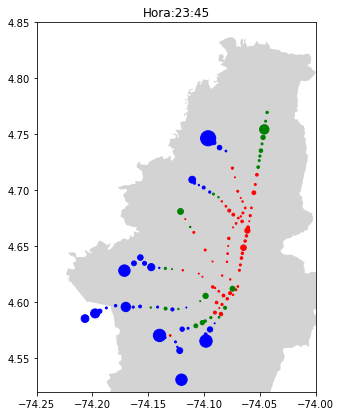

In [108]:
# Animacion por tamaño
for t in range(89):
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize = (5,7));
    minx, miny, maxx, maxy = [-74.25, 4.52, -74, 4.85]
    ax.set_xlim(minx, maxx);
    ax.set_ylim(miny, maxy);
    plot = gdf_polBog.plot(ax=ax, color='lightgrey');
    # Grafica de estaciones
    plot_stations(df_estaciones, clusterMarkerSize=dic_clusterSizes, col=t);
    ax.set_title("Hora:" + horas[t])
    display.clear_output(wait=True)
    plt.pause(0.01)
    plt.show();
